In [1]:
from ROOT import TMVA
from ROOT import TFile
from ROOT import TCut
from ROOT import gSystem, gROOT, gApplication

from keras import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.regularizers import l2
from tensorflow.keras.optimizers import SGD

# Setup TMVA
TMVA.Tools.Instance()
TMVA.PyMethodBase.PyInitialize()

Welcome to JupyROOT 6.24/06


2022-03-02 01:51:20.565777: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/root/lib:
2022-03-02 01:51:20.567361: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# output file
outNameLabel = "tmvaTraining"
outfileName = outNameLabel+".root"
outputFile = TFile.Open(outfileName, "RECREATE" );

# load the simulated data sets
inputSignal = TFile.Open("../Datasets/mc_345060.ggH125_ZZ4lep.4lep.root")
inputBG1 = TFile.Open("../Datasets/mc_363490.llll.4lep.root")
inputBG2 = TFile.Open("../Datasets/mc_345337.ZH125J_llWW2lep.4lep.root")

signal = inputSignal.Get("mini")
bg1 = inputBG1.Get("mini")
bg2 = inputBG2.Get("mini")

# book the TMVA methods
factory = TMVA.Factory("TMVAClassification", outputFile, "!V:!DrawProgressBar:Color:AnalysisType=Classification") 
dataloader = TMVA.DataLoader("dataloader_"+outNameLabel)

# define variables
# TODO: add more variables here
dataloader.AddVariable("lep_pt[0]",'F')
dataloader.AddVariable("lep_pt[0]+lep_pt[1]+lep_pt[2]+lep_pt[3]",'F')
dataloader.AddVariable("met_et",'F')
dataloader.AddVariable("jet_n",'I')

# TODO: further pre-select/clean-up data
selectionSig = "(trigE>0 || trigM > 0) && lep_n>=4 && lep_pt[0]<200e3 && (lep_pt[0]+lep_pt[1]+lep_pt[2]+lep_pt[3])<500e3 && met_et<200e3" 
selectionBG = selectionSig

# add trees and weights
dataloader.AddSignalTree(signal)
dataloader.AddBackgroundTree(bg1)
dataloader.AddBackgroundTree(bg2)

# event weights are added here - no problem for the BDT be careful with others
dataloader.SetSignalWeightExpression("mcWeight*scaleFactor_LepTRIGGER")
dataloader.SetBackgroundWeightExpression("mcWeight*scaleFactor_LepTRIGGER")

# TODO: change number of training and testing events here
dataloader.PrepareTrainingAndTestTree(TCut(selectionSig), TCut(selectionBG),
                                        "nTrain_Signal=5000:nTrain_Background=5000:nTest_Signal=5000:nTest_Background=5000:SplitMode=Random:NormMode=NumEvents:!V")

DataSetInfo              : [dataloader_tmvaTraining] : Added class "Signal"
                         : Add Tree mini of type Signal with 164716 events
DataSetInfo              : [dataloader_tmvaTraining] : Added class "Background"
                         : Add Tree mini of type Background with 554279 events
                         : Add Tree mini of type Background with 35694 events


In [3]:
# TODO: change training parameter settings here
factory.BookMethod(dataloader, TMVA.Types.kBDT, "BDT","!H:!V:NTrees=200:MaxDepth=4:BoostType=AdaBoost:AdaBoostBeta=0.15:SeparationType=GiniIndex:nCuts=100:MinNodeSize=5:PruneMethod=NoPruning")

Factory                  : Booking method: BDT
                         : 
                         : Building event vectors for type 2 Signal
                         : Dataset[dataloader_tmvaTraining] :  create input formulas for tree mini
                         : Building event vectors for type 2 Background
                         : Dataset[dataloader_tmvaTraining] :  create input formulas for tree mini
                         : Building event vectors for type 2 Background
                         : Dataset[dataloader_tmvaTraining] :  create input formulas for tree mini
DataSetFactory           : [dataloader_tmvaTraining] : Number of events in input trees
                         : Dataset[dataloader_tmvaTraining] :     Signal     requirement: "(trigE>0 || trigM > 0) && lep_n>=4 && lep_pt[0]<200e3 && (lep_pt[0]+lep_pt[1]+lep_pt[2]+lep_pt[3])<500e3 && met_et<200e3"
                         : Dataset[dataloader_tmvaTraining] :     Signal          -- number of events passed: 164189

In [4]:
# Training a Neural Network using the Keras Backend

# Define NN model
model = Sequential()
model.add(Dense(64, activation='relu', kernel_regularizer=l2(1e-5), input_dim=4))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(1e-5)))
model.add(Dense(2, activation='softmax'))

# Set loss and optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(learning_rate=0.01), metrics=['accuracy', ])

# Store model to file
model.save('model_tmva_class_keras.h5')
model.summary()

factory.BookMethod(dataloader, TMVA.Types.kPyKeras, 'PyKeras',
                   'H:!V:VarTransform=D,G:FilenameModel=model_tmva_class_keras.h5:NumEpochs=20:BatchSize=32')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                320       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 2)                 130       
                                                                 
Total params: 4,610
Trainable params: 4,610
Non-trainable params: 0
_________________________________________________________________


Factory                  : Booking method: PyKeras
                         : 
PyKeras                  : [dataloader_tmvaTraining] : Create Transformation "D" with events from all classes.
                         : 
                         : Transformation, Variable selection : 
                         : Input : variable 'lep_pt[0]' <---> Output : variable 'lep_pt[0]'
                         : Input : variable 'lep_pt[0]+lep_pt[1]+lep_pt[2]+lep_pt[3]' <---> Output : variable 'lep_pt[0]+lep_pt[1]+lep_pt[2]+lep_pt[3]'
                         : Input : variable 'met_et' <---> Output : variable 'met_et'
                         : Input : variable 'jet_n' <---> Output : variable 'jet_n'
PyKeras                  : [dataloader_tmvaTraining] : Create Transformation "G" with events from all classes.
                         : 
                         : Transformation, Variable selection : 
                         : Input : variable 'lep_pt[0]' <---> Output : variable 'lep_pt[0]'
       

2022-03-02 01:51:44.211675: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/root/lib:
2022-03-02 01:51:44.211913: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-02 01:51:44.212347: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (5d449486482b): /proc/driver/nvidia/version does not exist
2022-03-02 01:51:44.216047: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
factory.TrainAllMethods()
factory.TestAllMethods()
factory.EvaluateAllMethods()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                320       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 2)                 130       
                                                                 
Total params: 4,610
Trainable params: 4,610
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
213/250 [========================>.....] - ETA: 0s - loss: 0.6142 - accuracy: 0.6535
Epoch 1: val_loss improved from inf to 0.58060, saving model to dataloader_tmvaTraining/weights/TrainedModel_PyKeras.h5
250/250 [==============================] - 1s 4ms/step - loss: 0.6062 - accuracy: 0.6633 - val_loss: 0

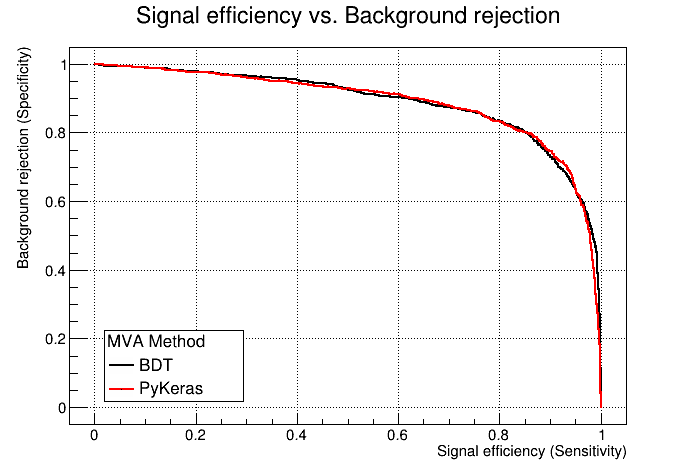

In [6]:
# We can now compare with our first BDT
cROC = factory.GetROCCurve(dataloader)
cROC.Draw()

## Exploring the methods using the TMVAGui

TMVA comes with the TMVAGui, which helps understand how the algorithms behave. To run it, simply run
```
root -l -e 'TMVA::TMVAGui("tmvaTraining.root")'
```
from your terminal.
